# Image Captioning 
by 余跃<br>
邮箱：974834832@qq.com
电话：17323073295<br>
改自（慕课网，tensorflow tutorial）

Inception v3 模型 拥有将近25,000,000个参数以及50亿个求和操作对于一张图片的分类。在现代的计算机就算没有GPU也能够在几分之一秒的时间完成一张图的分类。

## Flowchart（inception v3流程图）
![Inception v3](./img/inceptionv3onc--oview.png ) 

## Inception_v3详细图
![Inception_v3详细图](./img/inception_v3.png)

In [1]:
import tensorflow as tf
from tensorflow import gfile
import pickle
import math
from sequence2sequence import create_rnn_cell,dropout
import matplotlib.pyplot as plt
from tensorflow.contrib import seq2seq
from tensorflow import layers
from data_provide import Vocab,parse_token_file,convert_token_to_id,ImageCaptionData
import os
import sys
import pprint
import codecs
import jieba


input_description_file = "./data/clean_zh_results_20130124.token"
output_vocab_file = "./data/zh_vocab.txt"

In [2]:
def parse_token_file(token_file):
    """Parses token file.得到的输出是一个字典，key图像名称，value是一个列表，列表里面是对图像描述"""
    img_name_to_tokens = {}
    with gfile.GFile(token_file, 'r') as f:
        lines = f.readlines()
    for line in lines:
        img_id, description = line.strip('\r\n').split('\t')
        img_name, _ = img_id.split('#')
        img_name_to_tokens.setdefault(img_name, [])
        img_name_to_tokens[img_name].append(description)
    return img_name_to_tokens

In [3]:
img_name_to_tokens = parse_token_file(input_description_file)#img_name_to_tokens 一个字典，key图像名称，value描述。
all_img_names = img_name_to_tokens.keys()#获取所有的图像

In [4]:
list(all_img_names)[:10]

['7781342152.jpg',
 '3627679667.jpg',
 '1464513701.jpg',
 '2498093487.jpg',
 '2917193696.jpg',
 '4379763864.jpg',
 '3636126441.jpg',
 '7474389870.jpg',
 '437549483.jpg',
 '3484576025.jpg']

In [5]:
def show_image_caption(name,name_to_tokens):
    """
    
    加载和绘制图像，展示真实文本描述
    """

    #图像文件的路径
    path = './data/flickr30k_images/'
    image_path = path+name
    
    # Load the image and plot it.
    img = plt.imread(image_path)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img)
    plt.show()
    
    # Print the captions for this image. 打印图像的文本标注
    captions = name_to_tokens[name]
    for caption in captions:
        print(caption)

In [6]:
input_description_file = "./data/clean_zh_results_20130124.token"
input_img_feature_dir = "./feature_extraction_inception_v3"
input_vocab_file = "./data/zh_vocab.txt"
output_dir = "./local_run"
vocab_size=15939
img_feature_dim=2048

model_file = "./inception_v3/inception_v3_graph_def.pb"


In [7]:
def get_default_params():
    return tf.contrib.training.HParams(
        num_vocab_word_threshold=2,#出现频率比较低的词呢，就会被过滤掉，这里频率小于3的会被过滤掉。
        num_embedding_nodes=350,
        num_lstm_nodes=[350, 350], #每一层LSTM的大小，cell size
        num_lstm_layers=2,# 一共有两层LSTM
        batch_size=1,
        cell_type='lstm',
        clip_lstm_grads=1.0,#梯度剪裁
        learning_rate=0.001,
        keep_prob=1,#每一层循环神经网络都需要添加一个dropout么？还是全连接层才添加dropout，fc层也需要。
        log_frequent=100,#每隔100会打印一次log
        save_frequent=1000,#每隔多少次保存一次
    )

In [8]:
def load_graph(model_file):
    with gfile.FastGFile(model_file, "rb") as f:
        graph_def = tf.GraphDef()#这是构建一个空的计算图
        graph_def.ParseFromString(f.read())#这里是利用文件句柄把计算图读到空的计算图中去
        return graph_def

In [9]:
def get_image(img_path):
    '''
    读取一张图片
    :param img_path: flickr30k_images
    :return: 返回一张图像的二进制编码
    '''
    img_data = gfile.FastGFile(img_path, "rb").read()  # 根据名称读取flickr30k_images中的图像
    # img_data = plt.imread(img_path)
    return img_data

### 下面是真实的预测场景
    predict #1: img_feature -> embedding_img ->lstm -> a
    predict #2:a -> embedding_word -> lstm -> (b)
    predict #3:b -> embedding_word -> lstm -> (c)
    predict #4:c -> embedding_word -> lstm -> (d)
    predict #5:d -> embedding_word -> lstm -> (e)
    predict #6:e -> embedding_word -> lstm -> eos

In [10]:
def get_model(hps,vocab_size, img_feature_dim,img_feature):
    '''
    创建GreedyEmbeddingHelper、BasicDecoder，输入图像的Transfer Values，返回预测的结果
    
    return：outputs.sample_id,final_sequence_lengths,embed_img_input
            outputs.sample_id,预测的结果，final_sequence_lengths,预测句子的长度，embed_img_input：解码开始时，真实输入到
            解码器中的图像
    
    '''
    # Sets up the embedding layer.
    embedding_initializer = tf.random_uniform_initializer(-1.0, 1.0)
    with tf.variable_scope('embedding', initializer=embedding_initializer):
        embeddings = tf.get_variable(
            'embeddings',
            [vocab_size, hps.num_embedding_nodes],
            tf.float32)

    img_feature_embed_init = tf.uniform_unit_scaling_initializer(factor=1.0)
    with tf.variable_scope('image_feature_embed', initializer=img_feature_embed_init):
        embed_img = tf.layers.dense(img_feature, hps.num_embedding_nodes)#这里的embed_img用做解码器的输入
        embed_img = tf.layers.batch_normalization(embed_img)
        embed_img = tf.nn.relu(embed_img)
        embed_img_input = tf.reshape(embed_img,shape=(hps.batch_size,hps.num_embedding_nodes))

    decoder_output_projection = layers.Dense(
        vocab_size,
        dtype=tf.float32,
        use_bias=False,
        name='decoder_output_projection'
    )
    
    scale = 1.0 / math.sqrt(hps.num_embedding_nodes + hps.num_lstm_nodes[-1]) / 3.0
    lstm_init = tf.random_uniform_initializer(-scale, scale)
    with tf.variable_scope('lstm_nn', initializer=lstm_init) as test_scope:
        cells = []
        for i in range(hps.num_lstm_layers):
            cell = create_rnn_cell(hps.num_lstm_nodes[i], hps.cell_type)
            cell = dropout(cell, 1)
            cells.append(cell)
        cell = tf.contrib.rnn.MultiRNNCell(cells)
        initial_state = cell.zero_state(hps.batch_size, tf.float32)

    def embed_and_input_proj(inputs):
        '''
        这里根据inputs.name来判断是该返回图像的embed，还是word embed vector
        '''

        m = tf.nn.embedding_lookup(
            embeddings,
            inputs
        )
        
        if inputs.name =='image_embed_feature:0':
            print(inputs.name)
            return embed_img_input
        return m


    start_tokens = tf.tile([11],[hps.batch_size],name='image_embed_feature') #这个值可以填写任意的，这里选取的是11,

    decoding_helper = seq2seq.GreedyEmbeddingHelper(
        start_tokens=start_tokens,#这个是解码开始时，应该首先输入到解码器中去的，但在embed_and_input_proj函数需要替换成embed_img_input
        end_token=2,#这里vocab中的结束字符的编码为2
        embedding=embed_and_input_proj
    )

    inference_decoder = seq2seq.BasicDecoder(
        cell=cell,
        helper=decoding_helper,
        initial_state=initial_state,
        output_layer=decoder_output_projection
    )

    (
        outputs,
        final_state,
        final_sequence_lengths
    ) = (seq2seq.dynamic_decode(
        decoder=inference_decoder,
        output_time_major=False,
        maximum_iterations=30,
        swap_memory=True,
        scope=test_scope
    ))

    return outputs.sample_id,final_sequence_lengths,embed_img_input

In [11]:
hps=get_default_params()
graph = load_graph(model_file)
_ = tf.import_graph_def(graph,name='')
transfer_value = tf.placeholder(tf.float32,shape=(1,1,2048))
result = get_model(hps=hps,vocab_size=vocab_size,img_feature_dim=img_feature_dim,img_feature=transfer_value)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.
image_embed_feature:0


In [12]:
def show_img(img_path):
    img = plt.imread(img_path)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img)
    plt.show()

INFO:tensorflow:Restoring parameters from ./local_run/image_caption_50-31799


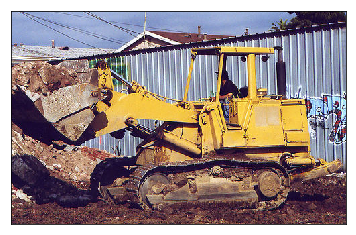

推土机正在挖掘建筑物基础中的土壤。


In [13]:
img_path = "./data/flickr30k_images/5566972.jpg"
img_data = get_image(img_path)
with tf.Session() as sess:
    tensor_img_transfer = sess.graph.get_tensor_by_name("pool_3:0")
    img = sess.run(tensor_img_transfer,feed_dict = {"DecodeJpeg/contents:0": img_data})[0]
#     print(img)
    sess.run(init)
    saver.restore(sess,save_path='./local_run/image_caption_50-31799')#加载模型参数
    show_result = sess.run(result,feed_dict={transfer_value: img})#传入参数，生成预测结果
    vocab = pickle.load(open('./vocab_pkl', 'rb'))#解码预测结果
    show_img(img_path)
#     print(img)
#     print(show_result[0])
    print(vocab.decode(show_result[0][0]))

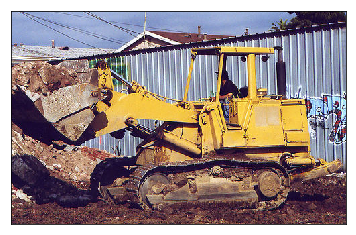

一名男子使用大型施工车辆移动污垢。
穿黑色衬衫的男子使用黄色推土机。
操作一台大黄色推土机的一个人。
工作的黄色推土机移动土。
拾起一些土的轮式装载机。


In [14]:
show_image_caption(name='5566972.jpg',name_to_tokens=img_name_to_tokens)